# generative model

####  何数学

In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import multivariate_normal

# >>> Part 1：数据预处理

#### 数据读入

In [2]:
data = pd.read_csv(r'.\dataset\train.csv')
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### 提取连续变量与分类变量列表：

In [4]:
con_rv = data.describe().columns # 连续变量
dis_rv = [x for x in data.columns if x not in con_rv]# 分类变量

#### 查看 train.csv 数据缺失情况：

In [5]:
for rv in data.columns:
#     print(rv,':  ',data[rv].unique())
    flag = ' ?' in data[rv].unique() 
    if flag == True:
        print(rv,'have missing value:',' ?' in data[rv].unique())
        print('   ','The proportion of missing values is:', round( data.loc[data[rv]==' ?'].shape[0] / data.shape[0] * 100, 2),'%' )

print('\nThe proportion of having ANY missing values is:', 
      round( data.loc[ (data['workclass']==' ?') | (data['occupation']==' ?') | (data['native_country']==' ?') ]
            .shape[0] / data.shape[0] * 100, 2),'%' )


workclass have missing value: True
    The proportion of missing values is: 5.64 %
occupation have missing value: True
    The proportion of missing values is: 5.66 %
native_country have missing value: True
    The proportion of missing values is: 1.79 %

The proportion of having ANY missing values is: 7.37 %


#### 查看 test.csv 数据缺失情况：

In [6]:
test_csv = pd.read_csv(r'.\dataset\test.csv')

for rv in test_csv.columns:
#     print(rv,':  ',data[rv].unique())
    flag = ' ?' in test_csv[rv].unique() 
    if flag == True:
        print(rv,'have missing value:',' ?' in test_csv[rv].unique())
        print('   ','The proportion of missing values is:', round( test_csv.loc[test_csv[rv]==' ?'].shape[0] / test_csv.shape[0] * 100, 2),'%' )

print('\nThe proportion of having ANY missing values is:', 
      round( test_csv.loc[ (test_csv['workclass']==' ?') | (test_csv['occupation']==' ?') | (test_csv['native_country']==' ?') ]
            .shape[0] / test_csv.shape[0] * 100, 2),'%' )

workclass have missing value: True
    The proportion of missing values is: 5.91 %
occupation have missing value: True
    The proportion of missing values is: 5.93 %
native_country have missing value: True
    The proportion of missing values is: 1.68 %

The proportion of having ANY missing values is: 7.5 %


#### 可以看到，train.csv 与 test.csv 数据缺失情况非常相近，均为缺失workclass、occupation、native_country三个分类变量。
#### 查看这三个变量分别取值：

In [7]:
for rv in ['workclass', 'occupation', 'native_country']:
    print(rv,':  ',data[rv].unique())

workclass :   [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
occupation :   [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
native_country :   [' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


#### 查看所有分类变量的分布情况：

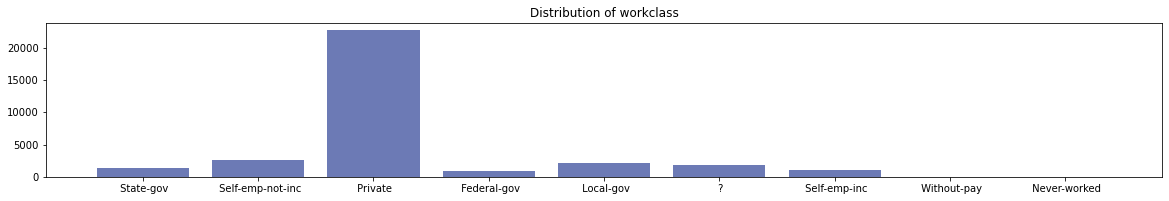

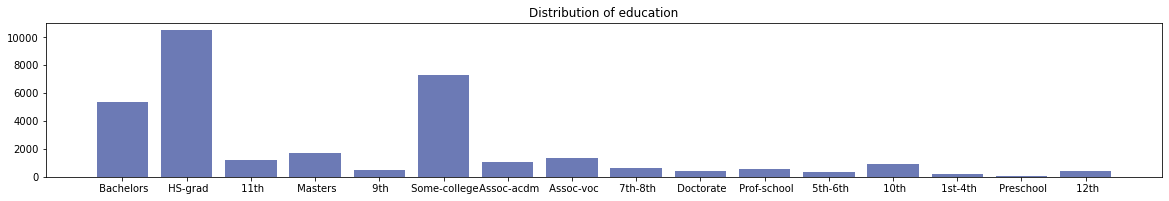

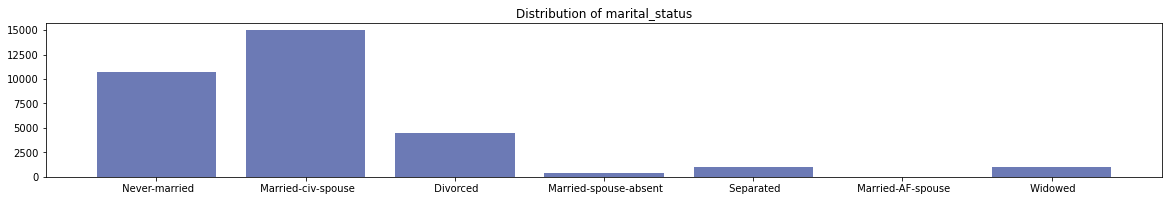

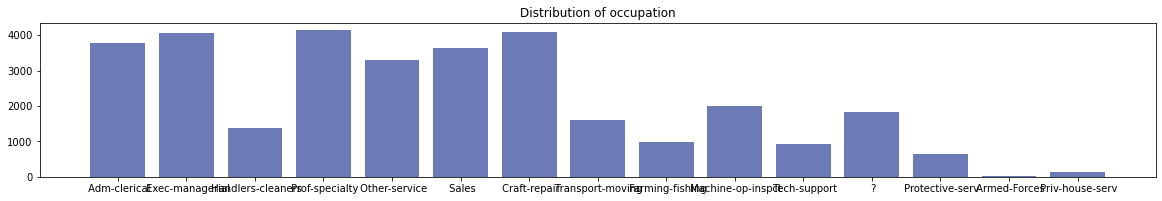

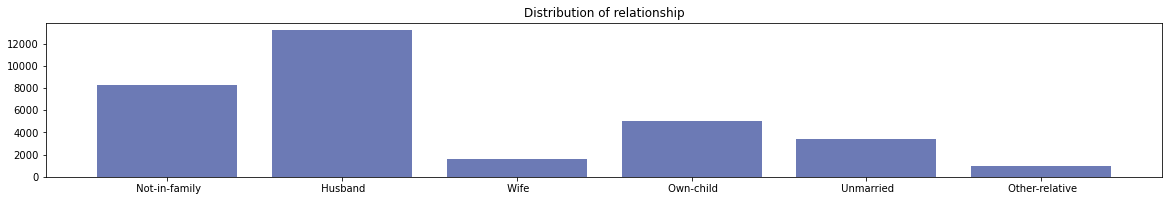

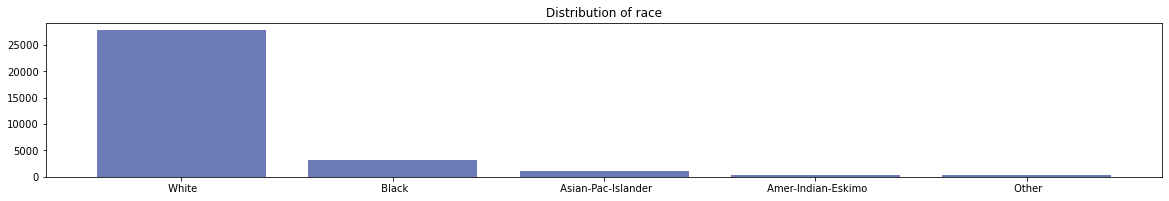

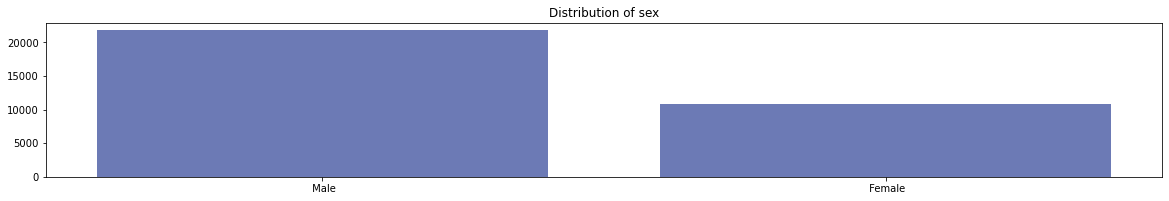

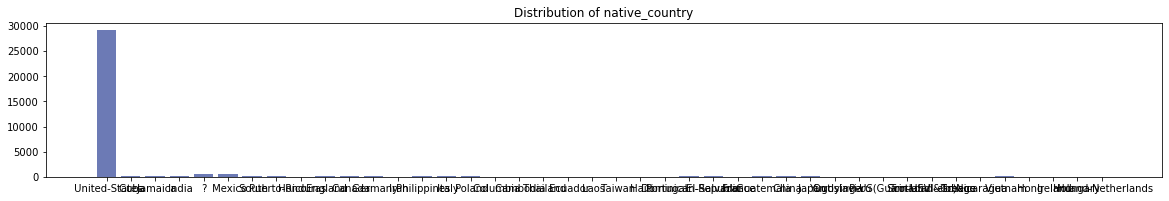

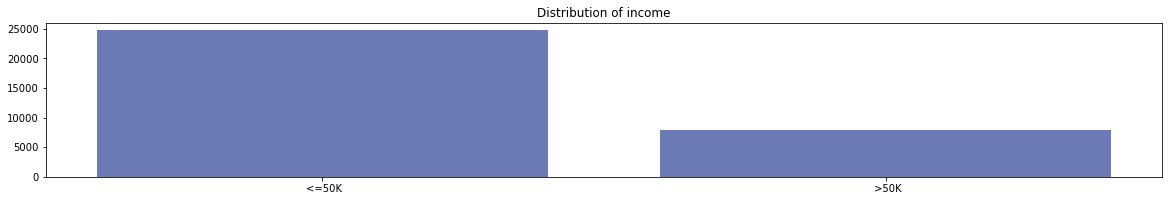

In [8]:
# for i, rv in enumerate(['workclass', 'occupation', 'native_country']):
for i, rv in enumerate(dis_rv):
    plt.figure(figsize = (20,30))
    plt.subplot(len(dis_rv),1, i+1)
#     plt.figure()
#     plt.hist(data[rv], color = '#2D3D8E', alpha=0.7)
    labels = data[rv].unique()
    prop = [data.loc[data[rv] == x].shape[0] for x in labels]

    plt.bar(range(len(labels)), prop, tick_label = labels, color = '#6C7AB5')
    plt.title('Distribution of '+rv)
    plt.show()


#### 综上，决定缺失值填补策略：
* **对 native_country，可以看到取值非常集中，绝大多数均为USA，因此以USA填充。**
* **对 workclass 和 occupation，可以看到取值较为分散，缺失值的占比比起其他类来说并不算小，因此认为缺失值自成一类。**

In [9]:
# native_country 缺失值填充
data['native_country'].loc[data['native_country'] == ' ?'] = ' United-States' 

**卡方检验：分贝变量之间是否独立**

In [12]:
# sex与workclass是否独立
chi2,pval,dof,expected = chi2_contingency(pd.crosstab(data['sex'], data['workclass']))
pval

1.0286039850311591e-160

In [13]:
# sex与relationship是否独立
chi2,pval,dof,expected = chi2_contingency(pd.crosstab(data['sex'], data['relationship']))
pval

0.0

#### 挑选了 sex 与 workclass、sex 与 relationship 两队变量做卡方检验，均不独立。
#### 虽然分类变量之间不独立，但也还是用一下朴素贝叶斯。

#### 查看连续变量的分布情况：

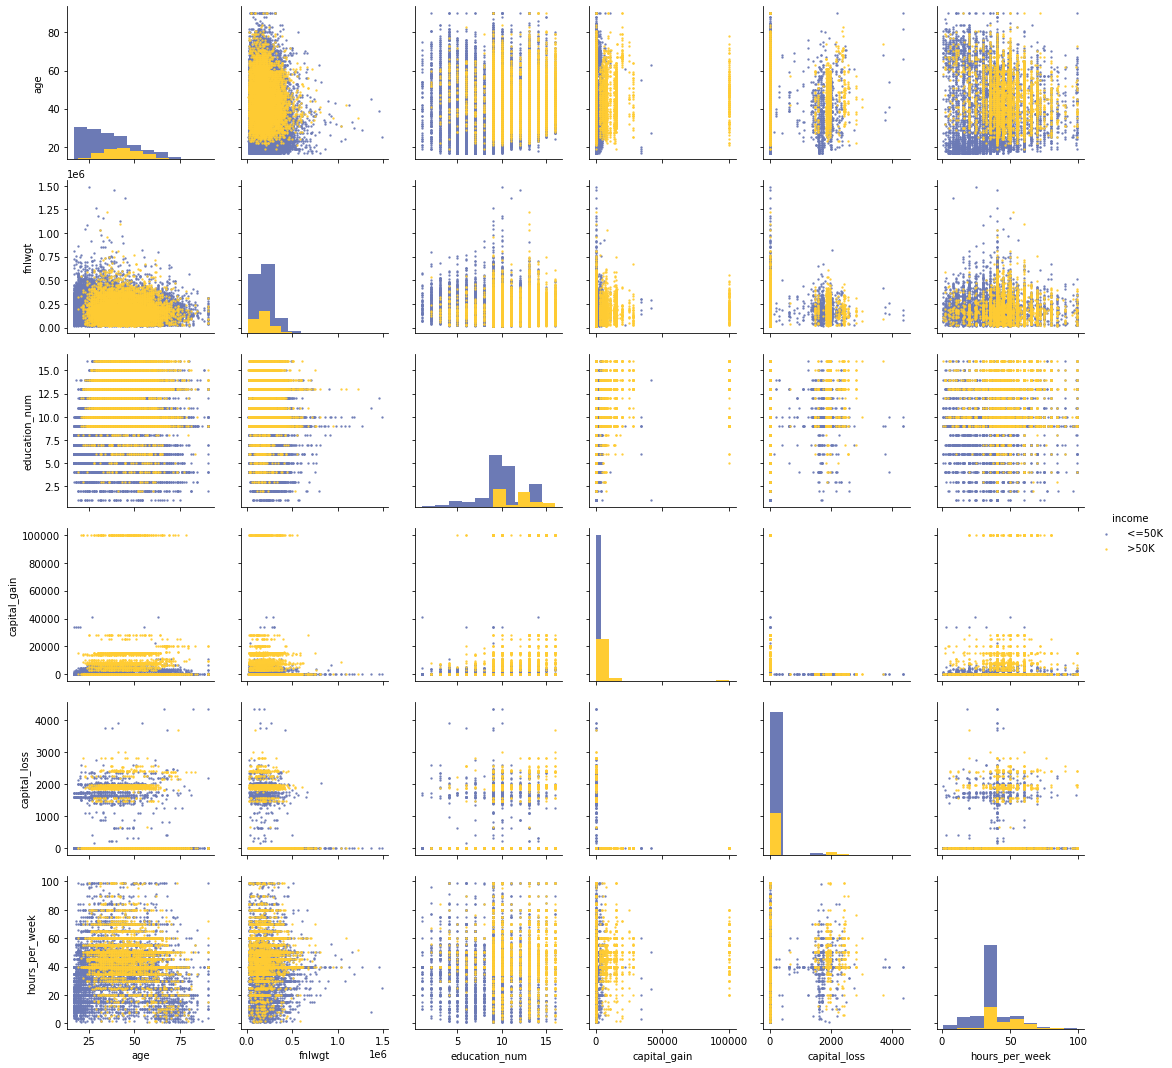

In [10]:
g = sns.PairGrid(data, hue = 'income', palette = {' <=50K':'#6C7AB5', ' >50K':'#FFCC33'})
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=2, alpha = 0.8)
g = g.add_legend()

#### 可以看到income 是否达到50K 在各个连续型变量上的分布有较大差异。

# >>> Part 2：提取模型

## 2.0 先定义分类器评价指标：

In [14]:
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score

def clf_Evaluate(df,y_pred,method):
    y_ = df.income.map({' >50K':1, ' <=50K':0})
    y_pred = y_pred.map({' >50K':1, ' <=50K':0})
    confusionmatrix = confusion_matrix(y_, y_pred)
    print('Confusion matrix:\n\n',confusionmatrix)
    print('\nClassification report:\n\n',classification_report(y_, y_pred))
    
    result = pd.DataFrame(columns = ['auc','accuracy','precision','recall','f1'])
    score_list = {
        'auc': round(roc_auc_score(y_, y_pred),4),
        'accuracy': round(accuracy_score(y_, y_pred),4),
        'precision': round(precision_score(y_, y_pred),4),
        'recall': round(recall_score(y_, y_pred),4),
        'f1': round(f1_score(y_, y_pred),4)
    }
    result = result.append(score_list, ignore_index=True)
    result.index = pd.Series([method])
    return result

## 2.1 连续变量未标准化：

#### 将 train.csv 分为测试集与训练集，占比分别为30%、70%。

In [27]:
print('Shape of total train.csv:', data.shape)
train_data = data.sample(frac = 0.75, random_state = 0, axis = 0, replace = False)
print('Shape of training data:', train_data.shape)
test_data = data[~data.index.isin(train_data.index)]
print('Shape of testing data:', test_data.shape)

Shape of total train.csv: (32561, 15)
Shape of training data: (24421, 15)
Shape of testing data: (8140, 15)


#### 计算概率生成模型所需的分类变量部分的概率和连续型变量部分的 likelihood:

In [30]:
Py0 = (train_data.income == ' <=50K').mean()
Py1 = 1 - Py0

y1_df = train_data[train_data.income == ' >50K'][con_rv]
miu1 = list(y1_df.mean())
X_c1 = y1_df - miu1
cov_matrix1 = X_c1.T @ X_c1 / y1_df.shape[0]

y0_df = train_data[train_data.income == ' <=50K'][con_rv]
miu0 = list(y0_df.mean())
X_c0 = y0_df - miu0
cov_matrix0 = X_c0.T @ X_c0 / y0_df.shape[0]

dis_rv.remove('income')

def cal_Py1_X(sample_series):
    
    # y = 1 时各概率计算
    Px_dis_y1 = 1 # Px_dis_y1: P(x1,...,x8|y=1) 类别变量部分的概率
    for i, rv in enumerate(dis_rv):
        Pxy1 = ((train_data[rv] == sample_series[rv]) & (train_data.income == ' >50K')).mean()
        Px_dis_y1 *= Pxy1 / Py1
    Px_con_y1 = multivariate_normal(mean=miu1, cov=cov_matrix1).pdf(sample_series[con_rv]) 
                    # Px_con_y1: P(x9,..,x13|y=1) 连续变量部分的概率
    Px_y1 = Px_dis_y1 * Px_con_y1
    
    # y = 0 时各概率计算
    Px_dis_y0 = 1 # Px_dis_y0: P(x1,...,x8|y=0) 类别变量部分的概率
    for i, rv in enumerate(dis_rv):
        Pxy0 = ((train_data[rv] == sample_series[rv]) & (train_data.income == ' <=50K')).mean()
        Px_dis_y0 *= Pxy0 / Py0    
    Px_con_y0 = multivariate_normal(mean=miu0, cov=cov_matrix0).pdf(sample_series[con_rv]) 
                    # Px_con_y0: P(x9,..,x13|y=0) 连续变量部分的概率
    Px_y0 = Px_dis_y0 * Px_con_y0
    z = np.log( Px_y1 * Py1 / Px_y0 / Py0 )
    
    return 1 / (1 + np.exp(-z))

In [204]:
# def predict_df(df):
#     y_pred = pd.Series(index = df.index)
#     for i in range(df.shape[0]):
#         y_pred.iloc[i] = ' >50K' if cal_Py1_X(df.iloc[i,:]) > 0.5 else ' <=50K'
#     return y_pred

In [ ]:
# def predict(row'):
#     for i in range(df.shape[0]):
#         y_pred.iloc[i] = ' >50K' if cal_Py1_X(df.iloc[i,:]) > 0.5 else ' <=50K'
#     return y_pred

In [205]:
# training_y_pred = predict_df(train_data)

KeyboardInterrupt: 

In [206]:

# training_y_pred = train_data.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
#                  axis = 1)

In [207]:
# training_y_pred

22278     <=50K
8950      <=50K
7838      <=50K
16505      >50K
19140      >50K
          ...  
29694     <=50K
16546     <=50K
17973     <=50K
8057      <=50K
13514      >50K
Length: 22793, dtype: object

#### 训练集上预测结果：

In [31]:
# 训练集上预测结果
training_y_pred = train_data.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
                 axis = 1)
clf_Evaluate(train_data, training_y_pred, 'Result on training data')

Confusion matrix:

 [[17269  1221]
 [ 2838  3093]]

Classification report:

               precision    recall  f1-score   support

           0       0.86      0.93      0.89     18490
           1       0.72      0.52      0.60      5931

   micro avg       0.83      0.83      0.83     24421
   macro avg       0.79      0.73      0.75     24421
weighted avg       0.82      0.83      0.82     24421



,auc,accuracy,precision,recall,f1
Result on training data,0.7277,0.8338,0.717,0.5215,0.6038


#### 测试集上预测结果：

In [32]:
# 测试集上预测结果
testing_y_pred = test_data.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
                 axis = 1)
clf_Evaluate(test_data, testing_y_pred, 'Result on testing data')

Confusion matrix:

 [[5807  423]
 [ 915  995]]

Classification report:

               precision    recall  f1-score   support

           0       0.86      0.93      0.90      6230
           1       0.70      0.52      0.60      1910

   micro avg       0.84      0.84      0.84      8140
   macro avg       0.78      0.73      0.75      8140
weighted avg       0.83      0.84      0.83      8140



,auc,accuracy,precision,recall,f1
Result on testing data,0.7265,0.8356,0.7017,0.5209,0.598


**训练集与测试集上结果相似，accuracy 为0.83~0.84，auc 为0.73，f1 为0.6。**

## 2.2 对连续变量实施标准化：

In [34]:
# 连续变量实施标准化
for rv in con_rv:
    miu = data[rv].mean()
    sigma = data[rv].var()**0.5
    data[rv] = (data[rv] - miu) / sigma

In [35]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.030670,State-gov,-1.063594,Bachelors,1.134721,Never-married,Adm-clerical,Not-in-family,White,Male,0.148451,-0.216656,-0.035429,United-States,<=50K
1,0.837096,Self-emp-not-inc,-1.008692,Bachelors,1.134721,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.145918,-0.216656,-2.222119,United-States,<=50K
2,-0.042641,Private,0.245075,HS-grad,-0.420053,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.145918,-0.216656,-0.035429,United-States,<=50K
3,1.057031,Private,0.425795,11th,-1.197440,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.145918,-0.216656,-0.035429,United-States,<=50K
4,-0.775756,Private,1.408154,Bachelors,1.134721,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.145918,-0.216656,-0.035429,Cuba,<=50K


#### 再分为测试集与训练集，占比分别为30%、70%。

In [36]:
train_data = data.sample(frac = 0.75, random_state = 0, axis = 0, replace = False)
print('Shape of training data:', train_data.shape)
test_data = data[~data.index.isin(train_data.index)]
print('Shape of testing data:', test_data.shape)

Shape of training data: (24421, 15)
Shape of testing data: (8140, 15)


#### 重新计算连续变量部分的 likelihood 所需的参数以及 likelihood：

In [38]:
# 重新计算likelihood所需的参数
y1_df = train_data[train_data.income == ' >50K'][con_rv]
miu1 = list(y1_df.mean())
X_c1 = y1_df - miu1
cov_matrix1 = X_c1.T @ X_c1 / y1_df.shape[0]

y0_df = train_data[train_data.income == ' <=50K'][con_rv]
miu0 = list(y0_df.mean())
X_c0 = y0_df - miu0
cov_matrix0 = X_c0.T @ X_c0 / y0_df.shape[0]

#### 训练集上预测结果：

In [39]:
training_y_pred = train_data.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
                 axis = 1)
clf_Evaluate(train_data, training_y_pred, 'Result on training data')

Confusion matrix:

 [[17269  1221]
 [ 2838  3093]]

Classification report:

               precision    recall  f1-score   support

           0       0.86      0.93      0.89     18490
           1       0.72      0.52      0.60      5931

   micro avg       0.83      0.83      0.83     24421
   macro avg       0.79      0.73      0.75     24421
weighted avg       0.82      0.83      0.82     24421



,auc,accuracy,precision,recall,f1
Result on training data,0.7277,0.8338,0.717,0.5215,0.6038


#### 测试集上预测结果：

In [40]:
# 测试集上预测结果
testing_y_pred = test_data.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
                 axis = 1)
clf_Evaluate(test_data, testing_y_pred, 'Result on testing data')

Confusion matrix:

 [[5807  423]
 [ 915  995]]

Classification report:

               precision    recall  f1-score   support

           0       0.86      0.93      0.90      6230
           1       0.70      0.52      0.60      1910

   micro avg       0.84      0.84      0.84      8140
   macro avg       0.78      0.73      0.75      8140
weighted avg       0.83      0.84      0.83      8140



,auc,accuracy,precision,recall,f1
Result on testing data,0.7265,0.8356,0.7017,0.5209,0.598


#### 证明了特征是否标准化对于概率生成模型没有影响。

# >>> Part 3：对 test.csv 预测

In [57]:
test_csv = pd.read_csv(r'.\dataset\test.csv')
# native_country 缺失值填充
test_csv['native_country'].loc[test_csv['native_country'] == ' ?'] = ' United-States' 

In [58]:
# 获取训练集的参数
data = pd.read_csv(r'.\dataset\train.csv')
test_csv['native_country'].loc[test_csv['native_country'] == ' ?'] = ' United-States' 
train_data = data.sample(frac = 0.75, random_state = 0, axis = 0, replace = False)

Py0 = (train_data.income == ' <=50K').mean()
Py1 = 1 - Py0

y1_df = train_data[train_data.income == ' >50K'][con_rv]
miu1 = list(y1_df.mean())
X_c1 = y1_df - miu1
cov_matrix1 = X_c1.T @ X_c1 / y1_df.shape[0]

y0_df = train_data[train_data.income == ' <=50K'][con_rv]
miu0 = list(y0_df.mean())
X_c0 = y0_df - miu0
cov_matrix0 = X_c0.T @ X_c0 / y0_df.shape[0]

In [59]:
# 预测
final_pred = test_csv.apply(lambda x: ' >50K' if cal_Py1_X(x) > 0.5 else ' <=50K',
                 axis = 1)

In [60]:
id_ = range(1,test_csv.shape[0]+1)

submission = pd.DataFrame(columns=['id','label'])
submission.id, submission.label = id_, final_pred
submission.to_csv('./submission_PGM.csv',index=False)
submission

,id,label
0,1,<=50K
1,2,<=50K
2,3,<=50K
3,4,>50K
4,5,<=50K
...,...,...
16276,16277,<=50K
16277,16278,<=50K
16278,16279,>50K
16279,16280,>50K
